In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

In [2]:
from timeit import default_timer as timer
from torch.profiler import profile, record_function, ProfilerActivity

In [3]:
# Check device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Utils Function

In [4]:
def print_train_time(start:float, end:float, device: torch.device = None):
    """print difference between start and end time"""
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [5]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [6]:
def results(res: str):
    res_lst = res.split('\n')

    data = []
    for row in res_lst[3:-4]:
        row_split = [sp.strip() for sp in row[57:].split('  ') if sp != '']
        data.append(row_split)

    index = [l[:57].strip() for l in res_lst[3:-4]]

    head = [c.strip() for c in res_lst[1].strip().split('  ') if c != '']

    df = pd.DataFrame(data, columns=None)
    df.columns = head[1:]
    df.index = index

    return df

# Model RNN

In [7]:
from training_function import train_step, test_step, accuracy_fn

In [8]:
# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Taking only the last output of the sequence
        return out

# Data

In [9]:
import joblib
from torch.utils import data

In [10]:
train_data = 'dataset/trainset_v2_500_label4.jb'
valid_data = 'dataset/testset_v2_500_label4.jb'

test_data = 'dataset/testing_500_label4.jb'

In [11]:
n_workers = 0
valid_steps = 1
save_steps = 50
epochs = 3

lr = 0.001
batch_size = 128

In [12]:
train_x, train_y = joblib.load(train_data)
val_x, val_y = joblib.load(valid_data)
test_x, test_y = joblib.load(test_data)

train_y, val_y, test_y = pd.get_dummies(train_y).values, pd.get_dummies(val_y).values,  pd.get_dummies(test_y).values

train_set = data.TensorDataset(torch.swapaxes(torch.Tensor(train_x), 1, 2), torch.Tensor(train_y))
valid_set = data.TensorDataset(torch.swapaxes(torch.Tensor(val_x), 1, 2), torch.Tensor(val_y))
test_set = data.TensorDataset(torch.swapaxes(torch.Tensor(test_x), 1, 2), torch.Tensor(test_y))

In [13]:
train_dataloader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=n_workers,
    # pin_memory=True
  )
valid_dataloader = DataLoader(
    valid_set,
    batch_size=batch_size,
    num_workers=n_workers,
    drop_last=True,
    # pin_memory=True
  )

test_dataloader = DataLoader(
    test_set,
    batch_size=len(test_set),
    num_workers=n_workers,
    drop_last=True,
    # pin_memory=True
  )

# Training Model RNN GPU

In [14]:
# Define the parameters
num_channels = 3
sequence_length = 500
hidden_units = 128
output_units = 2


# Create an instance of model_1
torch.manual_seed(42)
model = RNNModel(num_channels, hidden_units, output_units).to(device)
next(model.parameters()).device

device(type='cuda', index=0)

In [15]:
# Define loss function and optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

In [16]:
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True) as prof:
    start_time = timer()
    for epoch in tqdm(range(epochs)):
        print(f"Epoch: {epoch}\n-------------")

        train_step(model=model,
                   data_loader=train_dataloader, 
                   loss_fn=loss_fn,
                   optimizer=optimizer,
                   accuracy_fn=accuracy_fn,
                   device=device)

        test_step(model=model,
                   data_loader=valid_dataloader, 
                   loss_fn=loss_fn,
                   accuracy_fn=accuracy_fn,
                   device=device)
        prof.step()
    end_time = timer()
print(f'Time Consumtion: {end_time-start_time} sec')

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------------
Train loss: 0.25613 | Train acc: 66.38%
Test loss: 0.16537 | Test acc: 82.03 %

Epoch: 1
-------------
Train loss: 0.13523 | Train acc: 84.43%
Test loss: 0.10710 | Test acc: 88.16 %

Epoch: 2
-------------
Train loss: 0.09721 | Train acc: 89.06%
Test loss: 0.09498 | Test acc: 88.70 %

Time Consumtion: 4.032567600000002 sec


In [17]:
res = prof.key_averages().table()
print(res)

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::empty         0.34%      13.159ms         0.34%      13.159ms       2.371us      58.196ms         1.49%      58.196ms      10.486us     461.38 Kb     461.38 Kb     196.95 Gb     196.95 G

In [18]:
df = results(res)
df.to_csv('rnn_cuda.csv')

# Training Model RNN CPU

In [19]:
# Define the parameters
num_channels = 3
sequence_length = 500
hidden_units = 128
output_units = 2


# Create an instance of model_1
device = 'cpu'
torch.manual_seed(42)
model = RNNModel(num_channels, hidden_units, output_units).to(device)
next(model.parameters()).device

device(type='cpu')

In [20]:
# Define loss function and optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

In [21]:
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True) as prof:
    start_time = timer()
    for epoch in tqdm(range(epochs)):
        print(f"Epoch: {epoch}\n-------------")

        train_step(model=model,
                   data_loader=train_dataloader, 
                   loss_fn=loss_fn,
                   optimizer=optimizer,
                   accuracy_fn=accuracy_fn,
                   device=device)

        test_step(model=model,
                   data_loader=valid_dataloader, 
                   loss_fn=loss_fn,
                   accuracy_fn=accuracy_fn,
                   device=device)
        prof.step()
    end_time = timer()
print(f'Time Consumtion: {end_time-start_time} sec')

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------------
Train loss: 0.25614 | Train acc: 66.38%
Test loss: 0.16541 | Test acc: 82.03 %

Epoch: 1
-------------
Train loss: 0.13518 | Train acc: 84.46%
Test loss: 0.10707 | Test acc: 88.10 %

Epoch: 2
-------------
Train loss: 0.09719 | Train acc: 89.08%
Test loss: 0.09497 | Test acc: 88.70 %

Time Consumtion: 223.7397033 sec


In [22]:
res = prof.key_averages().table()
print(res)

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::empty         0.03%      71.275ms         0.03%      71.275ms      31.057us      84.601ms         0.04%      84.601ms      36.863us       9.84 Gb       9.84 Gb          2295  
                                          aten::random_         0.00%     127.000us         0.0

In [23]:
df = results(res)
df.to_csv('rnn_cpu.csv')

# Resource Consumtions of the Model

In [24]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [25]:
count_parameters(model)

17282

In [26]:
device = 'cpu'
model.to(device)

with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True) as prof:
    with torch.inference_mode():
        start_time = timer()
        for X, y in test_dataloader:
            # Send the data to the target device
            X, y = X.to(device), y.to(device)

            test_pred = model(X)
            
        end_time = timer()
print(f'Time Consumtion: {end_time-start_time} sec')

Time Consumtion: 5.111104800000021 sec


In [27]:
res = prof.key_averages().table()
print(res)
df = results(res)
df.to_csv('run_test_rnn_cpu.csv')

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::empty         0.17%       8.543ms         0.17%       8.543ms       1.220ms       8.887ms         0.18%       8.887ms       1.270ms      10.87 Mb      10.87 Mb             7  
                                          aten::random_         0.11%       5.664ms         0.1

In [29]:
# device = 'cuda'
# model.to(device)

# with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True) as prof:
#     with torch.inference_mode():
#         start_time = timer()
#         for X, y in test_dataloader:
#             # Send the data to the target device
#             X, y = X.to(device), y.to(device)

#             test_pred = model(X)
            
#         end_time = timer()
# print(f'Time Consumtion: {end_time-start_time} sec')

In [30]:
# res = prof.key_averages().table()
# print(res)
# df = results(res)
# df.to_csv('run_test_rnn_gpu.csv')

In [31]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [32]:
y_pred = test_pred.argmax(dim=1).cpu().numpy()
y_true = y.argmax(dim=1).cpu().numpy()
precision_recall_fscore_support(y_true, y_pred)

(array([1.        , 0.25984252]),
 array([0.94528522, 1.        ]),
 array([0.97187313, 0.4125    ]),
 array([1718,   33], dtype=int64))

In [33]:
cf_matrix = confusion_matrix(y_true, y_pred)

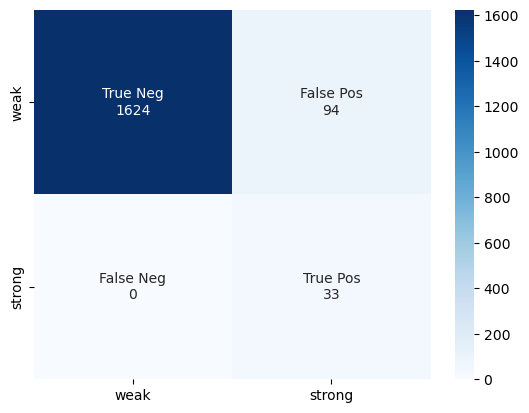

In [34]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2,2)

categories = ["weak", "strong"]
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues',xticklabels=categories, yticklabels=categories)
plt.savefig('cf_mat_rnn.png')